In [1]:
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.experiment import get_experiment_parameters
from orbit_generation.propagation import jacobi_constant
from orbit_generation.constants import EM_MU

In [2]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=100)
data.shape

(45211, 7, 100)

In [3]:
orbit_df

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods
0,1.0,0.941000,1.900442e-23,5.094743e-01,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0
1,1.0,0.941538,-8.592698e-24,5.086022e-01,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0
2,1.0,0.942076,6.956604e-24,5.077295e-01,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0
3,1.0,0.942613,1.763946e-24,5.068560e-01,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0
4,1.0,0.943150,9.441804e-24,5.059818e-01,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0
...,...,...,...,...,...,...,...,...,...,...,...
45206,42.0,1.261546,2.226244e-21,2.987754e-34,3.232867e-12,-0.802476,-4.045323e-33,2.587473,18.530504,3.702312,5.0
45207,42.0,1.261358,3.250690e-20,3.336112e-34,1.668217e-12,-0.802175,-2.163027e-33,2.587772,18.530028,3.709587,5.0
45208,42.0,1.261164,2.226243e-21,2.028433e-34,1.723199e-12,-0.801865,-3.682095e-33,2.588079,18.529537,3.717094,5.0
45209,42.0,1.260945,2.226241e-21,-7.922832e-34,4.493329e-12,-0.801516,8.675713e-33,2.588424,18.528983,3.725564,5.0


In [20]:
features=orbit_df[['id_class','jacobi','period','stability']]
features

,id_class,jacobi,period,stability
0,1.0,2.745412,11.555291,211.184678
1,1.0,2.746226,11.551622,210.329145
2,1.0,2.747039,11.547936,209.473685
3,1.0,2.747850,11.544233,208.618315
4,1.0,2.748660,11.540511,207.763051
...,...,...,...,...
45206,42.0,2.587473,18.530504,3.702312
45207,42.0,2.587772,18.530028,3.709587
45208,42.0,2.588079,18.529537,3.717094
45209,42.0,2.588424,18.528983,3.725564


In [26]:
X = orbit_df.drop(columns=['id_class'])
y = orbit_df['id_class']

In [11]:
classes=orbit_df['id_class']
classes

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
45206    42.0
45207    42.0
45208    42.0
45209    42.0
45210    42.0
Name: id_class, Length: 45211, dtype: float64

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_algorithms(X, y, print_results=False):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # List of algorithms to evaluate
    algorithms = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Support Vector Machine': SVC(),
        'Random Forest': RandomForestClassifier()
    }

    results = {}

    # Train and evaluate each algorithm
    for name, model in algorithms.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {'accuracy': accuracy, 'report': report}

    if print_results:
        visualize_results(results)

    return results

def visualize_results(results):
    # Accuracy comparison
    accuracies = [result['accuracy'] for result in results.values()]
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), accuracies)
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    # Detailed metrics heatmap
    metrics = ['precision', 'recall', 'f1-score']
    data = []
    for algo, result in results.items():
        for metric in metrics:
            value = np.mean([v[metric] for k, v in result['report'].items() if k != 'accuracy'])
            data.append([algo, metric, value])

    df = pd.DataFrame(data, columns=['Algorithm', 'Metric', 'Value'])
    pivot_df = df.pivot(index='Algorithm', columns='Metric', values='Value')

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('Performance Metrics Heatmap')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

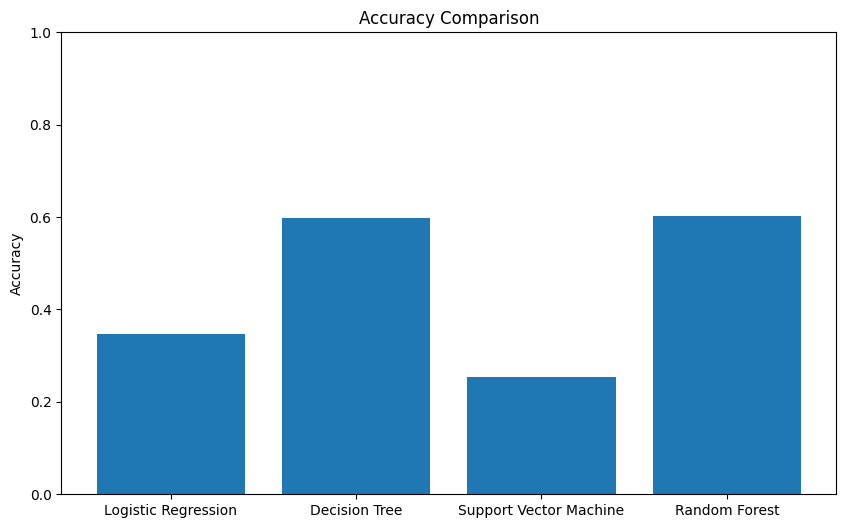

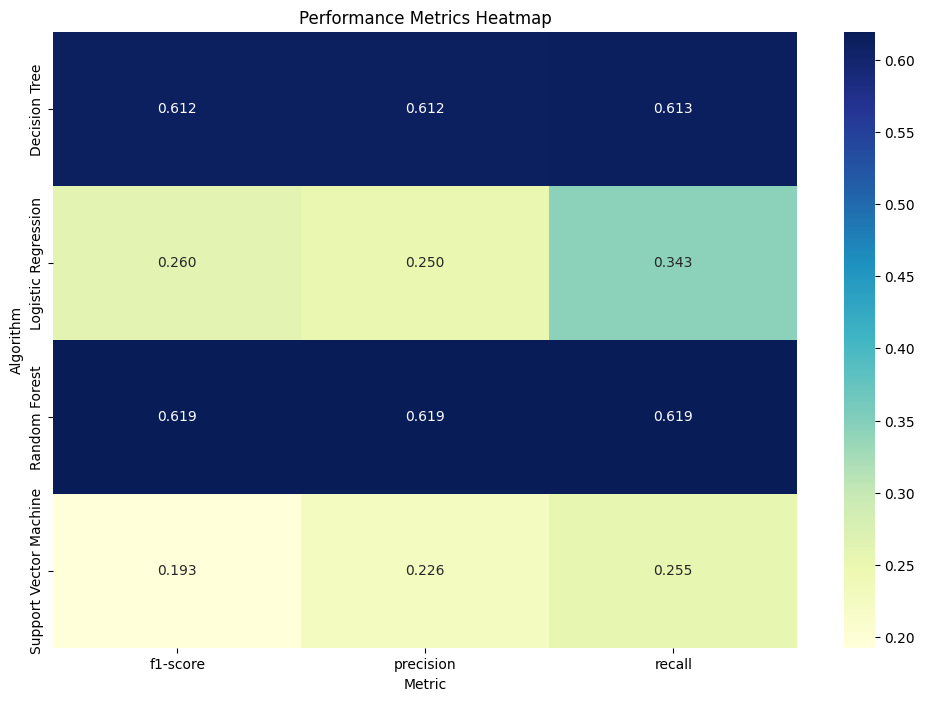

In [18]:
results = evaluate_algorithms(features,classes, print_results=True)

In [22]:
class_summary = features.groupby('id_class').agg(['mean', 'median', 'std', 'min', 'max'])

In [ ]:
for class_name in features['id_class'].unique():
    class_data = features[features['id_class'] == class_name].drop('id_class', axis=1)
    correlation = class_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Heatmap for Class {class_name}')
    plt.show()

In [34]:
centroids = features.groupby('id_class').mean()

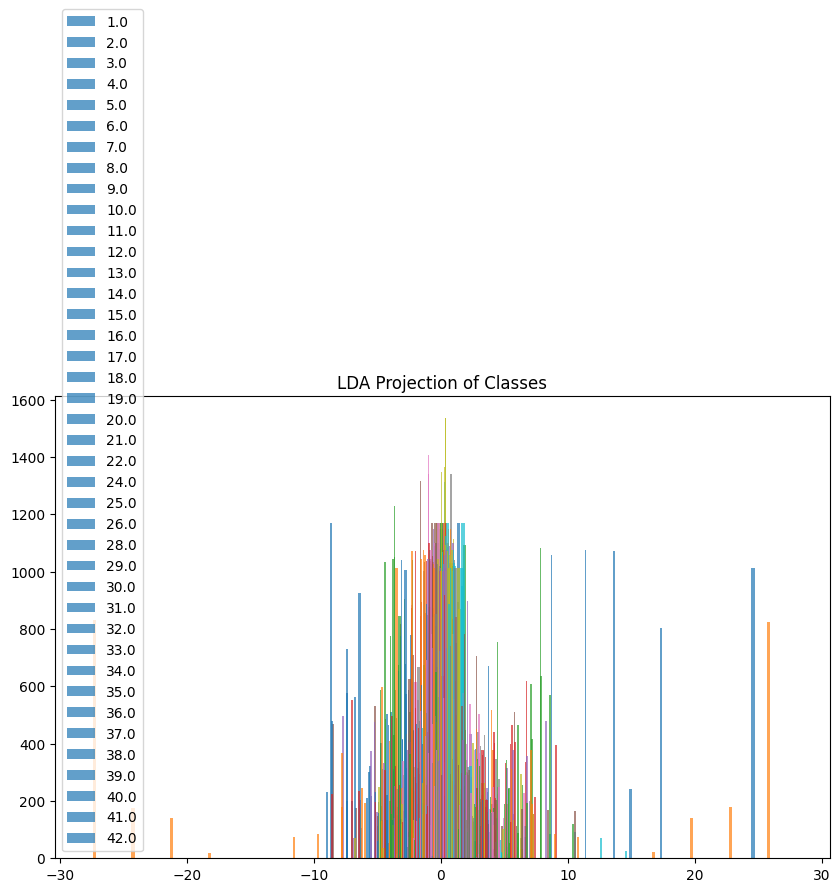

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

plt.figure(figsize=(10, 6))
for class_name in features['id_class'].unique():
    class_data = X_lda[y == class_name]
    plt.hist(class_data, alpha=0.7, label=class_name)
plt.legend()
plt.title('LDA Projection of Classes')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


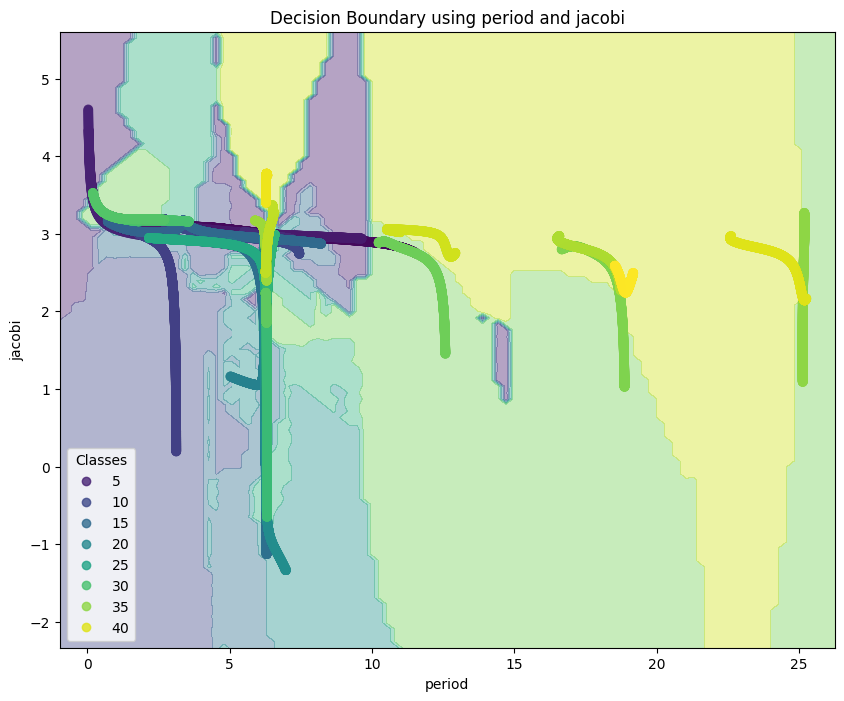

In [32]:
from sklearn.svm import SVC

def plot_decision_boundary(X, y, model, feature1, feature2):
    x1 = X[feature1]
    x2 = X[feature2]
    
    xx, yy = np.meshgrid(np.linspace(x1.min()-1, x1.max()+1, 100),
                         np.linspace(x2.min()-1, x2.max()+1, 100))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    scatter = plt.scatter(x1, x2, c=y, alpha=0.8)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'Decision Boundary using {feature1} and {feature2}')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

svm = SVC(kernel='rbf')
svm.fit(X[['period', 'jacobi']], y)
plot_decision_boundary(X, y, svm, 'period', 'jacobi')

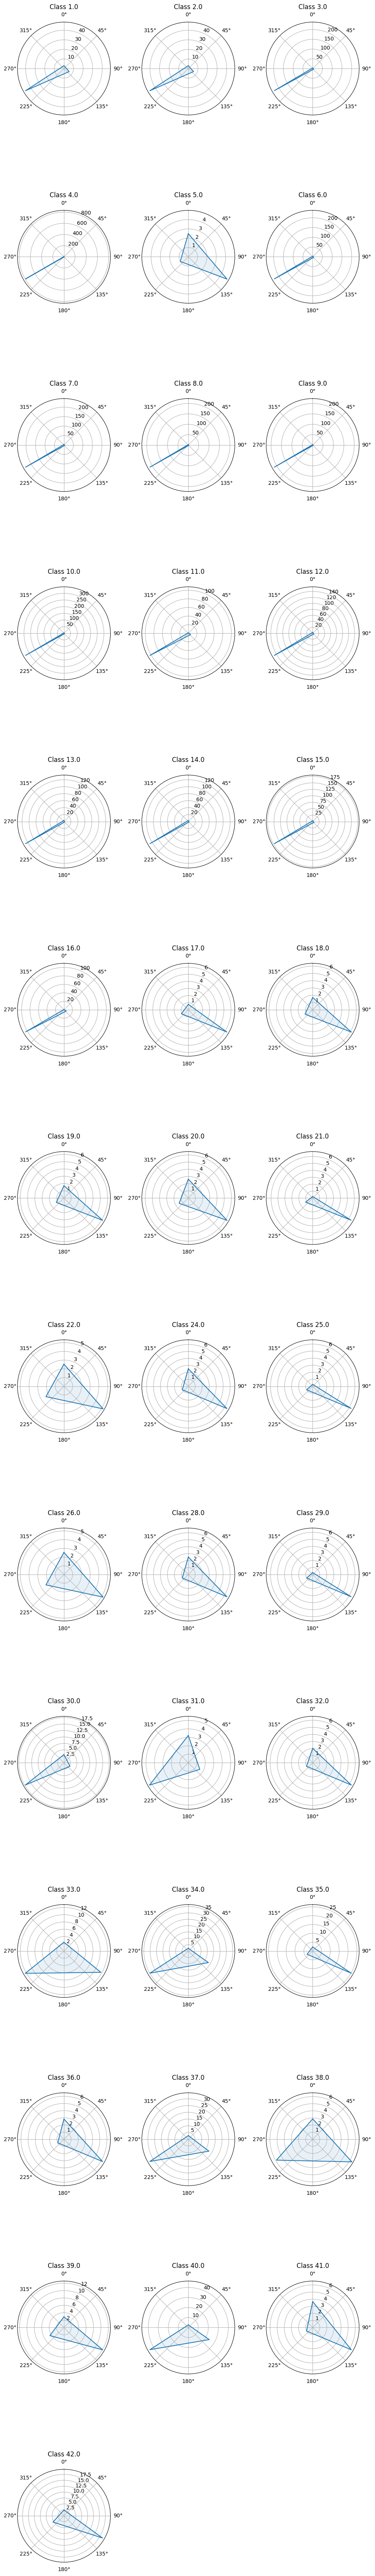

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def radar_chart(data, class_name, ax):
    categories = list(data.index)
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories)
    
    values = data.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.1)
    
    ax.set_title(f'Class {class_name}')

def plot_radar_charts(centroids, plots_per_row=2):
    num_classes = len(centroids)
    num_rows = (num_classes + plots_per_row - 1) // plots_per_row
    
    fig, axs = plt.subplots(num_rows, plots_per_row, subplot_kw=dict(polar=True), figsize=(10, num_rows * 5))
    axs = axs.flatten()
    
    for idx, class_name in enumerate(centroids.index):
        radar_chart(centroids.loc[class_name], class_name, axs[idx])
    
    for idx in range(num_classes, len(axs)):
        fig.delaxes(axs[idx])  # Remove unused subplots
    
    plt.tight_layout()
    plt.show()

plot_radar_charts(centroids, plots_per_row=3)